In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [2]:
data_dir = Path("../../data/processed")  
files = {
    "MF": data_dir / "players_data_MF_normalized.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_mf = load_clean(files["MF"])




# Cluster Defenders

In [3]:
print("MF shape:", df_mf.shape)
df_mf.head()
df_mf.info()
df_mf.describe()
df_mf.select_dtypes(include="object").columns

# drop_cols = ["__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
categorical_cols = ['Rk','Player', 'Nation', 'Pos','Squad', 'Comp', 'Age','Born','MP','Starts','Min','90s',
                    'numeric_wage', 'foot', 'W', 'D', 'L']
mf_features = df_mf.drop(columns=categorical_cols, errors="ignore")



# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", mf_features.shape)
mf_features.head()

mf_scaled = mf_features  # Data is already normalized

# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=2, random_state=42)
mf_pca = pca.fit_transform(mf_scaled)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, algorithm='elkan')
mf_clusters = kmeans.fit_predict(mf_pca)

# Add cluster labels to the original dataframe for easy reference
df_mf["cluster"] = mf_clusters

MF shape: (682, 129)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Columns: 129 entries, Rk to exposure_score
dtypes: float64(119), int64(4), object(6)
memory usage: 687.5+ KB
Numeric dataset shape: (682, 115)


### Plot and List

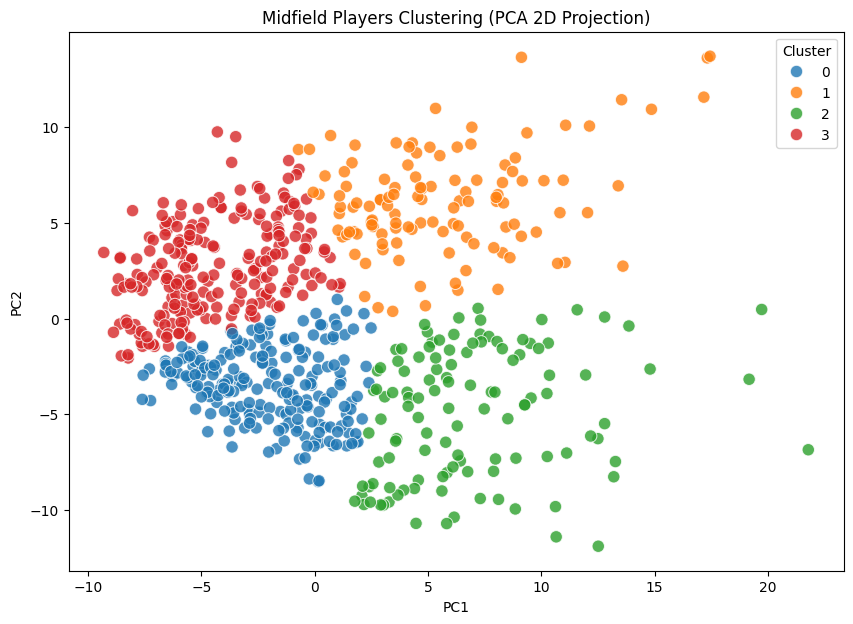

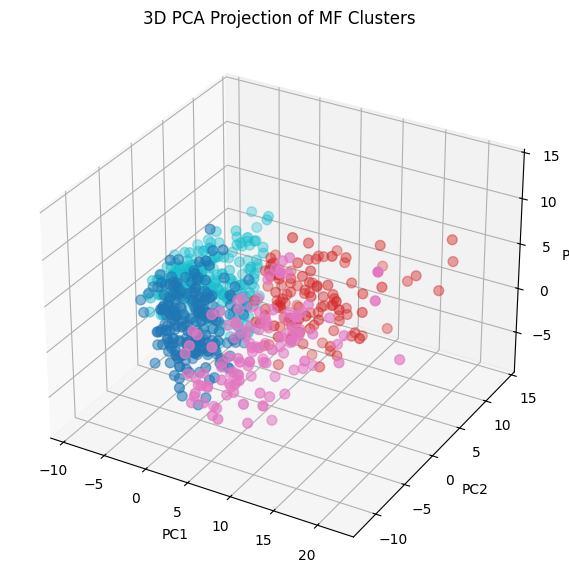

Eigenvalues (variance explained by each PC): [30.89452365 23.06659315  8.30647052]
Explained variance ratio: [0.27875312 0.20812377 0.07494709]
Cumulative variance explained: [0.27875312 0.4868769  0.56182398]


In [4]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=mf_pca[:,0], 
    y=mf_pca[:,1], 
    hue=df_mf["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Midfield Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Fit PCA for 3 components
pca_3d = PCA(n_components=3, random_state=42)
mf_pca_3d = pca_3d.fit_transform(mf_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    mf_pca_3d[:,0], mf_pca_3d[:,1], mf_pca_3d[:,2], 
    c=df_mf["cluster"], cmap="tab10", s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of MF Clusters")
plt.show()

# Print eigenvalues / explained variance
print("Eigenvalues (variance explained by each PC):", pca_3d.explained_variance_)
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca_3d.explained_variance_ratio_))


# Evaluate Defenders

In [5]:

sil_score = silhouette_score(mf_scaled, df_mf["cluster"])
print("Silhouette Score:", sil_score)


dbi = davies_bouldin_score(mf_scaled, df_mf["cluster"])
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(mf_scaled, df_mf["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=mf_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))

low_variance = mf_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.11722636035858824
Davies-Bouldin Index: 2.019783167883953
Calinski-Harabasz Score: 123.45276708147554
Top PC1 drivers:
 onxG                        0.157479
PassLive                    0.157155
Carries                     0.156744
TotDist_stats_possession    0.156051
Touches                     0.155592
Live_stats_possession       0.155538
Rec                         0.154248
SCA                         0.153088
onG                         0.151015
PrgDist_stats_possession    0.150998
Min%                        0.150485
exposure_score              0.149930
PrgP                        0.149348
Att 3rd_stats_possession    0.146899
Att                         0.146096
Name: PC1, dtype: float64

Top PC2 drivers:
 xG+xAG                      0.173102
Sh/90                       0.166745
Def 3rd_stats_possession    0.166608
SoT/90                      0.162039
Def Pen                     0.160730
Att Pen                     0.155886
PrgR                        0.151817
G

# Clustering Defenders with PC1 and PC2 Feature Selection

,Selected Features
0,Int
1,SCA
2,Tkl+Int
3,PrgP
4,onxG
5,Carries
6,Att 3rd_stats_possession
7,onG
8,PPA
9,exposure_score


K=4: Silhouette Score = 0.2386
Davies-Bouldin Index: 1.2942678153908989
Calinski-Harabasz Score: 293.6855894264782


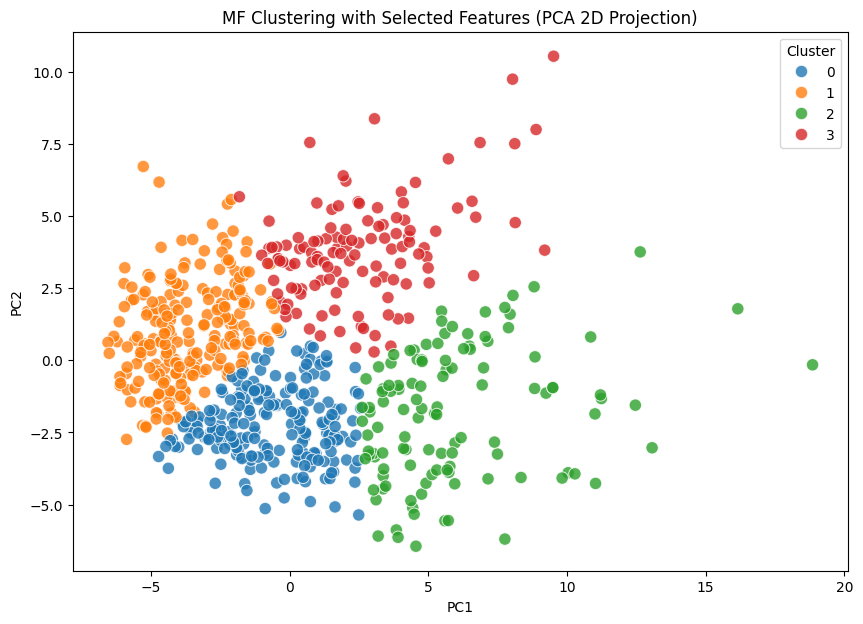

Players in cluster 0: 209


,Player,Squad,Pos,cluster
3,Tyler Adams,Bournemouth,MF,0
8,Lucien Agoume,Sevilla,MF,0
9,Ruben Aguilar,Lens,"DF,MF",0
10,Jean-Eudes Aholou,Angers,MF,0
15,Domingos André Ribeiro Almeida,Valencia,"MF,FW",0
...,...,...,...,...
658,Mats Wieffer,Brighton,"DF,MF",0
663,Harry Winks,Leicester City,MF,0
669,Yehor Yarmoliuk,Brentford,MF,0
670,Ryan Yates,Nott'ham Forest,MF,0


Players in cluster 1: 234


,Player,Squad,Pos,cluster
1,Ali Abdi,Nice,"DF,MF",1
2,Zakaria Aboukhlal,Toulouse,"MF,FW",1
4,Karim Adeyemi,Dortmund,"FW,MF",1
5,Simon Adingra,Brighton,"FW,MF",1
6,Yacine Adli,Fiorentina,MF,1
...,...,...,...,...
667,Jeong Woo-yeong,Union Berlin,"MF,FW",1
671,John Yeboah,Venezia,"FW,MF",1
676,Bryan Zaragoza,Osasuna,"FW,MF",1
677,Anass Zaroury,Lens,"FW,MF",1


Players in cluster 2: 117


,Player,Squad,Pos,cluster
0,Himad Abdelli,Angers,"MF,FW",2
21,Nadiem Amiri,Mainz 05,MF,2
22,Elliot Anderson,Nott'ham Forest,MF,2
23,André,Wolves,MF,2
24,Benjamin André,Lille,MF,2
...,...,...,...,...
668,Granit Xhaka,Leverkusen,MF,2
673,Warren Zaïre-Emery,Paris S-G,"MF,DF",2
674,Denis Zakaria,Monaco,MF,2
675,Andre-Frank Zambo Anguissa,Napoli,MF,2


Players in cluster 3: 122


,Player,Squad,Pos,cluster
11,Maghnes Akliouche,Monaco,"FW,MF",3
32,Hákon Arnar Haraldsson,Lille,"MF,FW",3
35,Iago Aspas,Celta Vigo,"FW,MF",3
45,Alex Baena,Villarreal,"MF,FW",3
49,Dilane Bakwa,Strasbourg,"MF,DF",3
...,...,...,...,...
645,Carlos Vicente,Alavés,"FW,MF",3
664,Florian Wirtz,Leverkusen,"MF,FW",3
666,Nick Woltemade,Stuttgart,"FW,MF",3
672,Kenan Yıldız,Juventus,"FW,MF",3


In [ ]:
# Drop features with low variance and select top features from PC1 and PC2
selected_features = list(loadings_PC1.head(20).index) + list(loadings_PC2.head(10).index)
selected_features = list(set(selected_features))  # Remove duplicates
selected_features_df = pd.DataFrame(selected_features, columns=["Selected Features"])
display(selected_features_df)



mf_scaled_sel = df_mf[selected_features].copy()
# Make Nan values 0
# fw_sel = fw_sel.fillna(0)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# fw_scaled_sel = scaler.fit_transform(fw_sel)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(mf_scaled_sel)
sil = silhouette_score(mf_scaled_sel, clusters)
print(f"K=4: Silhouette Score = {sil:.4f}")

# Evaluate
dbi = davies_bouldin_score(mf_scaled_sel, clusters)
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(mf_scaled_sel, clusters)
print("Calinski-Harabasz Score:", ch_score)

# Add cluster labels to the original dataframe for easy reference
df_mf["cluster"] = clusters

# Plotting with selected features
pca_sel = PCA(n_components=2, random_state=42)
mf_pca_sel = pca_sel.fit_transform(mf_scaled_sel)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=mf_pca_sel[:,0], 
    y=mf_pca_sel[:,1], 
    hue=clusters,       
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("MF Clustering with Selected Features (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# List players from cluster 1

cluster_0_players = df_mf[df_mf["cluster"] == 0][["Player", "Squad", "Pos", "cluster"]]
cluster_1_players = df_mf[df_mf["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
cluster_2_players = df_mf[df_mf["cluster"] == 2][["Player", "Squad", "Pos", "cluster"]]
cluster_3_players = df_mf[df_mf["cluster"] == 3][["Player", "Squad", "Pos", "cluster"]]

print(f"Players in cluster 0: {len(cluster_0_players)}")
display(cluster_0_players)
print(f"Players in cluster 1: {len(cluster_1_players)}")
display(cluster_1_players)
print(f"Players in cluster 2: {len(cluster_2_players)}")
display(cluster_2_players)
print(f"Players in cluster 3: {len(cluster_3_players)}")
display(cluster_3_players)







In [18]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

feature_cols = selected_features
X = mf_scaled_sel.values
labels = clusters

per_cluster_nn = {}
per_cluster_idx = {}

for c in np.unique(labels):
    indx = np.where(labels == c)[0]
    Xc = X[indx, :]
    # n_neighbors+1 to allow excluding self at query time
    nn = NearestNeighbors(n_neighbors=min(11, len(indx)), metric="euclidean", algorithm="auto")
    nn.fit(Xc)
    per_cluster_nn[c] = nn
    per_cluster_idx[c] = indx

def nearest_players_within_cluster(df, player_name=None, row_idx=None, k=5, id_col="Player"):
    if player_name is None and row_idx is None:
        raise ValueError("Provide either player_name or row_idx.")
    if row_idx is None:
        match = df.index[df[id_col] == player_name].tolist()
        if not match:
            raise ValueError(f"Player '{player_name}' not found in column '{id_col}'.")
        row_idx = match[0]

    c = labels[row_idx]
    nn = per_cluster_nn[c]
    idx = per_cluster_idx[c]

    xq = X[row_idx].reshape(1, -1)
    n_q = min(k+1, len(idx))
    dists, inds = nn.kneighbors(xq, n_neighbors=n_q)
    dists, inds = dists[0], inds[0]

    global_inds = idx[inds]
    mask = global_inds != row_idx
    global_inds = global_inds[mask]
    dists = dists[mask]
    global_inds = global_inds[:k]
    dists = dists[:k]

    cols_to_show = [c for c in [id_col, "Rk", "Pos", "Squad", "cluster"] if c in df.columns]
    out = df.iloc[global_inds][cols_to_show].copy()
    out["distance"] = dists
    return out.reset_index(drop=True)

# Example usage:
display(nearest_players_within_cluster(df_mf, player_name="Kevin De Bruyne", k=10))


,Player,Rk,Pos,Squad,cluster,distance
0,Lee Kang-in,1319,"FW,MF",Paris S-G,3,2.521603
1,Isco,1222,MF,Betis,3,2.961481
2,Phil Foden,910,"MF,FW",Manchester City,3,3.053987
3,Charles De Ketelaere,681,"MF,FW",Atalanta,3,3.476421
4,Désiré Doué,776,"FW,MF",Paris S-G,3,3.482640
5,Xavi Simons,2429,MF,RB Leipzig,3,3.488979
6,Antoine Griezmann,1064,"FW,MF",Atlético Madrid,3,3.671899
7,Marcus Tavernier,2557,"FW,MF",Bournemouth,3,3.713405
8,Eliesse Ben Seghir,294,"MF,FW",Monaco,3,3.757149
9,Iago Aspas,168,"FW,MF",Celta Vigo,3,3.789339
